In [8]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import sklearn
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os
plt.rcParams["font.size"] = 18

base_dir = '/home/ytakahashi/project/kaggle/PLAsTiCC'

## Read File

In [2]:
train_meta_df = pd.read_csv(os.path.join(base_dir, 'data/training_set_metadata.csv'))
test_meta_df = pd.read_csv(os.path.join(base_dir, 'data/test_set_metadata.csv'))
train_df = pq.read_table(os.path.join(base_dir, 'data/training_set.parquet')).to_pandas()
test_df = pq.read_table(os.path.join(base_dir, 'data/test_set.parquet')).to_pandas()

## Aggregation by ID and Passband

In [3]:
train_df['flux_ratio_sq'] = np.power(train_df['flux'] / train_df['flux_err'], 2.0)
train_df['flux_by_flux_ratio_sq'] = train_df['flux'] * train_df['flux_ratio_sq']
train_df['abs_flux'] = np.abs(train_df['flux'])

aggs = {
    'mjd': ['min', 'max', 'size'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'abs_flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

In [19]:
def split_aggs(aggs, max_num_split):
    col_opp_list = [ (item[0], [opp]) for item in aggs.items() for opp in item[1] ]
    num_split = min(len(col_opp_list), max_num_split)
    split_size = len(col_opp_list) / num_split
    splited = [col_opp_list[int(i*split_size) : int((i+1)*split_size)] for i in range(num_split)]
    res = []
    for partition in splited:
        aggs4node = {}
        for mini_tuple in partition:
            if mini_tuple[0] in aggs4node.keys():
                aggs4node[mini_tuple[0]].extend(mini_tuple[1])
            else :
                aggs4node[mini_tuple[0]] = mini_tuple[1]
        res.append(aggs4node)
    return res

In [20]:
def local_func(args):
    data_path, aggs, save_path = args
    train_df = pq.read_table(data_path).to_pandas()
    agged_df = train_df.groupby(['object_id','passband']).agg(aggs)
    agged_df = agged_df.unstack()
    levels = agged_df.columns.levels
    labels = agged_df.columns.labels
    
    # Set new column name
    col_names, mode_names, passband_names = levels
    col_ids, mode_ids, passband_ids = labels
    agged_cols = ['{0},{1},{2}'.format(col_names[col_id], mode_names[mode_id], passband_names[passband_id]) for col_id, mode_id, passband_id in zip(col_ids, mode_ids, passband_ids)]
    agged_df.columns = agged_cols
    
    agged_df.to_parquet(save_path, engine='pyarrow')
    print('end agg: {0}'.format(str(aggs)))

In [10]:
def parallel_preprocess(dataframe, aggs, n_jobs, tmp_dir=os.path.join(base_dir, 'tmp')):
    df_src_path = os.path.join(tmp_dir, 'df_src_tmp.parquet')
    dataframe.to_parquet(df_src_path, engine='pyarrow')
    with Pool(n_jobs) as p:
        data_path_list = [df_src_path] * n_jobs
        aggs_list = split_aggs(aggs, n_jobs)
        job_id_list = range(n_jobs)
        save_path_list = [os.path.join(tmp_dir, 'df_result_part{0}.parquet'.format(job_id)) for job_id in range(n_jobs)]
        print()
        p.map(local_func, zip(data_path_list, aggs_list, save_path_list))
    return pd.concat([pd.read_parquet(path, engine='pyarrow') for path in save_path_list], axis=1)

In [11]:
%%time
train_agged_df = parallel_preprocess(train_df, aggs, 26)

CPU times: user 1.7 s, sys: 9.86 s, total: 11.6 s
Wall time: 19.8 s


## Merge Metadata and Split Galactic

In [12]:
train_merged = pd.merge(train_agged_df, train_meta_df, on='object_id')
train_galactic = train_merged[train_merged.hostgal_photoz == 0]
train_extra = train_merged[~(train_merged.hostgal_photoz == 0)]

In [13]:
train_galactic.fillna(0, inplace=True)
train_extra.fillna(0, inplace=True)

/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## Train with LightGBM

In [14]:
galactic_targets = np.unique(train_galactic.target)
extra_targets = np.unique(train_extra.target)

In [15]:
labels2weight = {x:1 for x in np.concatenate([galactic_targets,extra_targets])}
labels2weight[64] = 2
labels2weight[15] = 2

params = {
    "num_leaves" : [31],
    "max_depth" : [-1, 5], # -1
    "learning_rate" : [0.03,0.05,0.08], # 0.1
    "n_estimators" : [100, 200, 400], # 100
    "min_child_weight" : [0.001, 0.01], # 0.001
    "reg_lambda" : [0.0, 0.01], # 0.0
    "verbosity" : [-1],
    "n_jobs" : [2]
}

In [16]:
from sklearn.model_selection import GridSearchCV

def lgbm_gridsearch_cv(train_data, target,params, labels2weight, grid_jobs):
    
    labels2y = dict(map(reversed, enumerate(np.unique(target))))
    y2labels = dict(enumerate(np.unique(target)))
    y = np.array(list(map(labels2y.get, target)))
    label_weights = {key : labels2weight[value] for key,value in y2labels.items()}
    
    lgb_clf = lgb.LGBMClassifier(objective='multiclass', class_weight=label_weights)
    grid_clf = GridSearchCV(lgb_clf, params, scoring='neg_log_loss', cv=5, n_jobs=grid_jobs, return_train_score=True)
    return (grid_clf.fit(train_data, y), y2labels)


### Parallelism configuration benchmarks
- grid serial using cpu is 81.46618032455444 
- grid serial using gpu is 238.99585008621216
- lightgbm parallelism:4, grid parallelism :9 is 9.447643041610718
- lightgbm using GPU, grid parallelism: 4 is error

In [17]:
%%time
galactic_cv_res, galactic_y2labels = lgbm_gridsearch_cv(train_galactic.drop('target',axis=1), \
                                        train_galactic.target, \
                                        params,  \
                                        labels2weight, \
                                        40)

CPU times: user 16.6 s, sys: 12.4 s, total: 29 s
Wall time: 3min 58s


In [18]:
%%time
extra_cv_res, extra_y2labels = lgbm_gridsearch_cv(train_extra.drop('target',axis=1), \
                                        train_extra.target, \
                                        params,  \
                                        labels2weight, \
                                        40)

CPU times: user 30.8 s, sys: 13.2 s, total: 44 s
Wall time: 12min 20s


## Training Result and Prediction

In [21]:
print('Galactic best validation log_loss is {0}'.format(- galactic_cv_res.best_score_))
print('Extra best validation log_loss is {0}'.format(- extra_cv_res.best_score_))

Galactic best validation log_loss is 0.13750726604169883
Extra best validation log_loss is 1.0748377889419733


In [22]:
galactic_best_clf = galactic_cv_res.best_estimator_
extra_best_clf = extra_cv_res.best_estimator_

## Test Data Conversion

## Aggregation by ID and Passband

In [23]:
test_df['flux_ratio_sq'] = np.power(test_df['flux'] / test_df['flux_err'], 2.0)
test_df['flux_by_flux_ratio_sq'] = test_df['flux'] * test_df['flux_ratio_sq']
test_df['abs_flux'] = np.abs(test_df['flux'])

In [24]:
%%time
test_agged_df = parallel_preprocess(test_df, aggs, 26)

Exception in thread Thread-56:
Traceback (most recent call last):
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python

end agg: {'mjd': ['max']}
end agg: {'abs_flux': ['min']}


Process ForkPoolWorker-144:
Process ForkPoolWorker-151:
Traceback (most recent call last):
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Process ForkPoolWorker-160:
Process ForkPoolWorker-159:
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-156:
Process ForkPoolWorker-147:
Process ForkPoolWorker-154:
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-143:
Process ForkPoolWorker-140:
Process ForkPoolWorker-152:
Process ForkPoolWorker-138:
Process ForkPoolWorker-145:


KeyboardInterrupt: 

Process ForkPoolWorker-139:
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-142:
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  Fil

  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/ytakahashi/library/anaconda2/envs/kaggle/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrup

In [36]:
pat = test_df.loc[:,['object_id','passband','flux']]

In [ ]:
%time pat.groupby(['object_id','passband']).skew()

## Merge Metadata and Split Galactic

In [ ]:
test_merged = pd.merge(test_agged_df, test_meta_df, on='object_id')
test_galactic = test_merged[test_merged.hostgal_photoz == 0]
test_extra = test_merged[~(test_merged.hostgal_photoz == 0)]

In [ ]:
test_galactic.fillna(0, inplace=True)
test_extra.fillna(0, inplace=True)

In [ ]:
galactic_pred_df = pd.DataFrame(galactic_best_clf.predict(test_galactic, raw_score=True))
galactic_pred_df.columns = ['class_{0}'.format(galactic_y2labels[i]) for i in galactic_pred_df.columns]

extra_pred_df = pd.DataFrame(extra_best_clf.predict(test_extra, raw_score=True))
extra_pred_df.columns = ['class_{0}'.format(extra_y2labels[i]) for i in extra_pred_df.columns]

## Save or Load

In [ ]:
'''
galactic_best_clf.booster_.save_model(os.path.join(base_dir, 'result/galactic_model'))
extra_best_clf.booster.save_model(os.path.join(base_dir, 'result/extra_model'))
'''

In [ ]:

galactic_model = lgb.Booster(model_file=os.path.join(base_dir, 'result/galactic_model'))
galactic_pred_label = galactic_model.predict( test_galactic.loc[:,galactic_features], raw_score=True)
galactic_pred_df = pd.DataFrame({'class_{0}'.format(c): galactic_pred_label[:, i] for i,c in enumerate(np.unique(galactic_targets))})
extra_model = lgb.Booster(model_file=os.path.join(base_dir, 'result/extra_model'))
extra_pred_label = extra_model.predict( test_extra.loc[:,extra_features], raw_score=True)
extra_pred_df = pd.DataFrame({'class_{0}'.format(c): extra_pred_label[:, i] for i,c in enumerate(np.unique(extra_targets))})


## Feature Importance

In [17]:
features = train_merged.columns.values[~(train_merged.columns.values == 'target')]
galactic_importance = pd.DataFrame({'features':features,
                                    'importance':galactic_best_clf.feature_importances_})
extra_importance = pd.DataFrame({'features':features,
                                    'importance':extra_best_clf.feature_importances_})

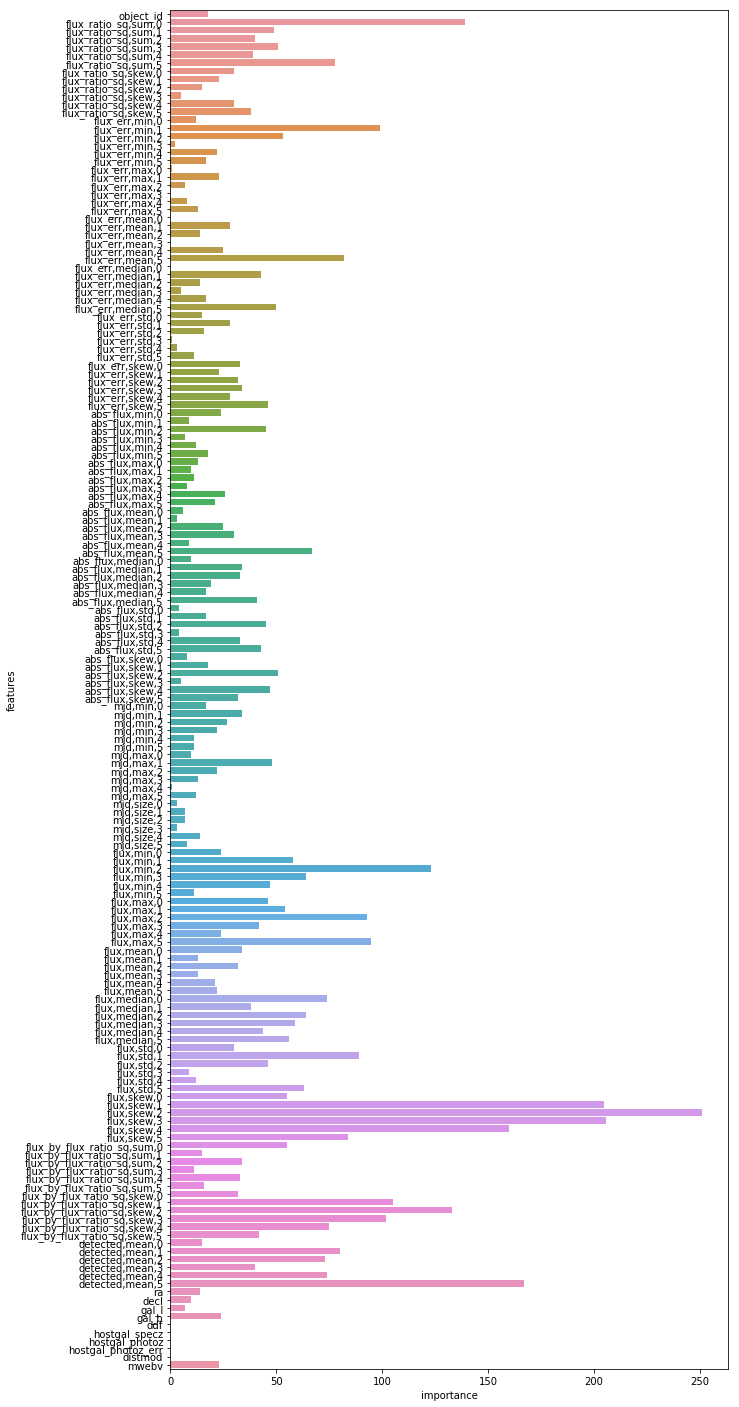

In [25]:
plt.figure(figsize=(10,25))
sns.barplot(y='features',x='importance',data=galactic_importance)

## Add class_99

In [ ]:
galactic_pred_df['class_99'] = np.mean(galactic_pred_df,axis=1)
galactic_pred_df = (np.exp(galactic_pred_df).T / np.sum(np.exp(galactic_pred_df),axis=1)).T

extra_pred_df['class_99'] = np.mean(extra_pred_df,axis=1)
extra_pred_df = (np.exp(extra_pred_df).T / np.sum(np.exp(extra_pred_df),axis=1)).T

## Merge Galactic and Extragalactic

In [ ]:
galactic_pred_df['object_id'] = test_galactic.object_id.values
extra_pred_df['object_id'] = test_extra.object_id.values

pred_df = pd.concat([galactic_pred_df, extra_pred_df],axis=0,sort=True)
pred_df.fillna(value=0,inplace=True)

pred_df.sort_values(by='object_id',inplace=True)

## Count Average Score

In [93]:
galactic_naive_pred = pd.DataFrame(train_galactic.target.value_counts() / len(train_galactic)).T
galactic_naive_pred.rename(columns={i:'class_{0}'.format(i) for i in galactic_naive_pred.columns}, inplace=True)
galactic_naive_df = pd.concat([galactic_naive_pred] * len(test_galactic))
galactic_naive_df['object_id'] = test_galactic.object_id.values
galactic_naive_df.reset_index(drop=True, inplace=True)

extra_naive_pred = pd.DataFrame(train_extra.target.value_counts() / len(train_extra)).T
extra_naive_pred.rename(columns={i:'class_{0}'.format(i) for i in extra_naive_pred.columns}, inplace=True)
extra_naive_df = pd.concat([extra_naive_pred] * len(test_extra))
extra_naive_df['object_id'] = test_extra.object_id.values
extra_naive_df.reset_index(drop=True, inplace=True)

In [94]:
naive_pred = pd.concat([galactic_naive_df, extra_naive_df], axis=0, sort=True)
naive_pred.fillna(value=0, inplace=True)
naive_pred['class_99'] = 0.0

### Merge Average Score

In [100]:
naive_pred.sort_values(by='object_id',inplace=True)
pred_df.sort_values(by='object_id',inplace=True)
aved_pred = (pred_df.drop('object_id', axis=1) + naive_pred.drop('object_id', axis=1) ) / 2
aved_pred['object_id'] = pred_df.object_id

## Count Even Score

In [36]:
even_galactic = pd.DataFrame([[1/(len(galactic_targets) + 1)] * (len(galactic_targets) + 1)] * len(test_galactic))
even_galactic.rename(columns={i:'class_{0}'.format(galactic_targets[i]) for i in range(len(galactic_targets))}, inplace=True)
even_galactic.rename(columns={len(galactic_targets):'class_99'}, inplace=True)
even_galactic['object_id'] = test_galactic.object_id.values

even_extra = pd.DataFrame([[1/(len(extra_targets) + 1)] * (len(extra_targets) + 1)] * len(test_extra))
even_extra.rename(columns={i:'class_{0}'.format(extra_targets[i]) for i in range(len(extra_targets))}, inplace=True)
even_extra.rename(columns={len(extra_targets):'class_99'}, inplace=True)
even_extra['object_id'] = test_extra.object_id.values

even_pred = pd.concat([even_galactic, even_extra], axis=0, sort=True)
even_pred.fillna(value=0, inplace=True)

### Merge Even Score

In [38]:
even_pred.sort_values(by='object_id',inplace=True)
pred_df.sort_values(by='object_id',inplace=True)
aved_pred = (pred_df.drop('object_id', axis=1) + even_pred.drop('object_id', axis=1) ) / 2
aved_pred['object_id'] = pred_df.object_id

## Weighted Naive Score

In [68]:
from sklearn.preprocessing import normalize

weighted_galactic = pd.DataFrame([[1] * (len(galactic_targets) + 1)] * len(test_galactic))
weighted_galactic.columns = ['class_{0}'.format(class_id) for class_id in np.concatenate((galactic_targets,[99]))]
weighted_galactic.loc[:,:] = normalize(weighted_galactic, norm='l1')
weighted_galactic['object_id'] = test_galactic.object_id.values

weighted_extra = pd.DataFrame([[1] * (len(extra_targets) + 1)] * len(test_extra))
weighted_extra.columns = ['class_{0}'.format(class_id) for class_id in np.concatenate((extra_targets,[99]))]
weighted_extra.loc[:,['class_15','class_64']] = weighted_extra.loc[:,['class_15','class_64']] *2
weighted_extra.loc[:,:] = normalize(weighted_extra, norm='l1')
weighted_extra['object_id'] = test_extra.object_id.values

weighted_pred = pd.concat([weighted_galactic, weighted_extra], axis=0, sort=True)
weighted_pred.fillna(value=0, inplace=True)

### Merge Weighted Naive Score

In [69]:
weighted_pred.sort_values(by='object_id',inplace=True)
pred_df.sort_values(by='object_id',inplace=True)
aved_pred = (pred_df.drop('object_id', axis=1) + weighted_pred.drop('object_id', axis=1) ) / 2
aved_pred['object_id'] = pred_df.object_id

In [70]:
aved_pred.to_csv(os.path.join(base_dir, 'result/weighted_aved_lgb.csv'),float_format='%.8f', index=False)

In [ ]:
pred_df.to_csv(os.path.join(base_dir, 'result/agged_lgb.csv'),float_format='%.8f', index=False)